In [42]:
# 引入必要库
import pyecharts
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# windows和mac设置中文字体的方式不一样，这里需注意根据实际情况调整
# plt.rcParams['font.sans-serif'] = ['SimHei']
%matplotlib inline
import matplotlib
myfont = matplotlib.font_manager.FontProperties(fname='../zhaozi.ttf', size=14) # 为了显示中文
sns.set(font=myfont.get_name())

In [43]:
# 函数默认返回北京市2018年1月到12月的url，可以自行调整
def get_url(city='beijing'):
    '''
    city为城市拼写的字符串，year为年份+月份
    '''
    for time in range(201801,201813):
        url = "http://lishi.tianqi.com/{}/{}.html".format(city,time)
        yield url

In [104]:
# 这里需要加上自己的cookies
def get_datas(urls = get_url()):
    cookie = {"cityPy":"sanming; cityPy_expire=1551775148; UM_distinctid=16928f54c6d0-08753ecf8a3d56-5d4e211f-1fa400-16928f54c6e445; CNZZDATA1275796416=308465049-1551166484-null%7C1551172369; Hm_lvt_ab6a683aa97a52202eab5b3a9042a8d2=1551170359,1551172902; Hm_lpvt_ab6a683aa97a52202eab5b3a9042a8d2=1551172902"}
    header = {"User-Agent":"Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/55.0.2883.87 Safari/537.36"}
    for url in urls:
        html = requests.get(url = url, headers = header, cookies=cookie)
        soup = BeautifulSoup(html.content, 'html.parser')
        date = soup.select("#tool_site > div.tqtongji2 > ul > li:nth-of-type(1) > a")
        max_temp = soup.select("#tool_site > div.tqtongji2 > ul > li:nth-of-type(2)")
        min_temp = soup.select("#tool_site > div.tqtongji2 > ul > li:nth-of-type(3)")
        weather = soup.select("#tool_site > div.tqtongji2 > ul > li:nth-of-type(4)")
        wind_direction = soup.select("#tool_site > div.tqtongji2 > ul > li:nth-of-type(5)")
        date = [x.text for x in date]
        max_temp = [x.text for x in max_temp[1:]]
        min_temp = [x.text for x in min_temp[1:]]
        weather = [x.text for x in weather[1:]]
        wind_direction = [x.text for x in wind_direction[1:]]
        yield pd.DataFrame([date,max_temp,min_temp,weather,wind_direction]).T

In [105]:
# 获取数据方法
def get_result():
    result = pd.DataFrame()
    for data in get_datas():  
        result = result.append(data)
    return result

In [106]:
# 执行方法，获取数据
result = get_result()

# 是否存在非空数据
print('空数据有',result.isnull().any().sum())

# 简单查看下爬取到的数据
result.head(5)

空数据有 0


,0,1,2,3,4
0,2018-01-01,3,-6,晴,东风
1,2018-01-02,2,-5,多云,北风
2,2018-01-03,2,-5,多云,西北风
3,2018-01-04,-1,-7,阴,西南风
4,2018-01-05,3,-6,多云,西风


In [107]:
# 改一下列名
result.columns = ["日期","最高温度","最低温度","天气状况","风向"]
# 由于提取的默认是字符串，所以这里更改一下数据类型
result['日期'] = pd.to_datetime(result['日期'])
result["最高温度"] = pd.to_numeric(result['最高温度'])
result["最低温度"] = pd.to_numeric(result['最低温度'])
result["平均温度"] = (result['最高温度'] + result['最低温度'])/2
# 看一下更改后的数据状况
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 361 entries, 0 to 30
Data columns (total 6 columns):
日期      361 non-null datetime64[ns]
最高温度    361 non-null int64
最低温度    361 non-null int64
天气状况    361 non-null object
风向      361 non-null object
平均温度    361 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 19.7+ KB


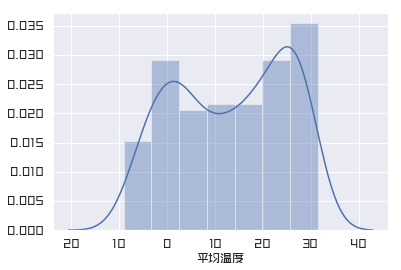

In [108]:
# 温度的分布
sns.distplot(result['平均温度'])


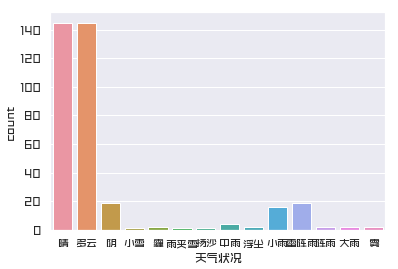

In [114]:
# 天气状况分布
sns.countplot(result['天气状况'])

In [115]:
# 按月份统计降雨和没有降雨的天气数量

result['是否降水'] = result['天气状况'].apply(lambda x:'未降水' if x in ['晴','多云','阴','雾','浮尘','霾','扬沙'] else '降水')
rain = result.groupby([result['日期'].apply(lambda x:x.month),'是否降水'])['是否降水'].count()

month = [str(i)+"月份" for i in range(1,13)]
is_rain = [rain[i]['降水'] if '降水' in rain[i].index else 0 for i in range(1,13)]
no_rain = [rain[i]['未降水'] if '未降水' in rain[i].index else 0  for i in range(1,13)]

line = pyecharts.Line("各月降水天数统计")

line.add(
    "降水天数",
    month,
    is_rain,
    is_fill=True,
    area_opacity=0.7,
    is_stack = True)

line.add(
    "未降水天数",
    month,
    no_rain,
    is_fill=True,
    area_opacity=0.7,
    is_stack = True)
line

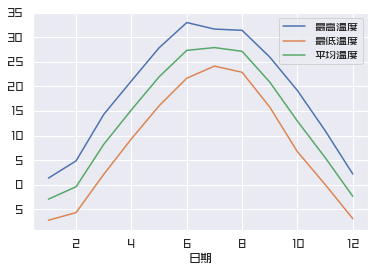

In [116]:
# 按照月份查看最高、最低、平均温度的走势
result.groupby(result['日期'].apply(lambda x:x.month)).mean().plot(kind='line')

In [12]:
directions = ['北风', '西北风', '西风', '西南风', '南风', '东南风', '东风', '东北风']
schema = []
v = []
days = result['风向'].value_counts()
for d in directions:
    schema.append((d,100))
    v.append(days[d])
v = [v]
radar = pyecharts.Radar()
radar.config(schema)
radar.add("风向统计", v, is_axisline_show=True)
radar